# Clustering (Customers Segmentation with K-Means)

## Step0: Set Up (Load Libraries)

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

import warnings
warnings.simplefilter("ignore")

In [3]:
pd.set_option('display.max_rows', None)

## Step1: Load Data

In [4]:
file_path = 'https://raw.githubusercontent.com/PPWorkSpace1/Clustering/main/Transactions.csv'

df = pd.read_csv(file_path)

Mounted at /content/drive


## Step2: Data Exploration

In [5]:
# Preview first 5 rows

df.head()

,order_id,customer_id,product_category,price,freight_value,payment_value,payment_type,payment_installments,order_purchase,order_approved_at,order_status,order_delivered_carrier_date,order_delivered_customer_date,shipping_limit_date,order_estimated_delivery_date,customer_age,customer_city,customer_region,customer_state,ratings
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,cool_stuff,58.90,13.29,72.19,credit_card,2,9/13/2017 8:59,9/13/2017 9:45,delivered,9/19/2017 18:34,9/20/2017 23:43,9/19/2017 9:45,9/29/2017 0:00,73,campos dos goytacazes,southeast,RJ,5.0
1,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,sports_leisure,185.00,13.63,397.26,credit_card,8,1/11/2018 15:30,1/11/2018 15:47,delivered,1/12/2018 21:57,1/17/2018 18:42,1/18/2018 15:47,2/2/2018 0:00,49,osasco,southeast,SP,4.0
2,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,pet_shop,239.90,19.93,259.83,credit_card,3,4/26/2017 10:53,4/26/2017 11:05,delivered,5/4/2017 14:35,5/12/2017 16:04,5/3/2017 11:05,5/15/2017 0:00,45,santa fe do sul,southeast,SP,4.0
3,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,computers_accessories,79.79,8.30,88.09,credit_card,1,2/28/2018 12:25,2/28/2018 12:48,delivered,3/2/2018 19:08,3/9/2018 23:17,3/6/2018 12:48,3/14/2018 0:00,22,nova odessa,southeast,SP,5.0
4,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,furniture_decor,199.00,17.87,216.87,credit_card,5,1/14/2018 14:33,1/14/2018 14:48,delivered,1/16/2018 12:36,1/22/2018 13:19,1/18/2018 14:48,2/5/2018 0:00,53,para de minas,southeast,MG,5.0


In [6]:
# Data Summary

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104158 entries, 0 to 104157
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       104158 non-null  object 
 1   customer_id                    104158 non-null  object 
 2   product_category               104158 non-null  object 
 3   price                          104158 non-null  float64
 4   freight_value                  104158 non-null  float64
 5   payment_value                  104158 non-null  float64
 6   payment_type                   104158 non-null  object 
 7   payment_installments           104158 non-null  int64  
 8   order_purchase                 104158 non-null  object 
 9   order_approved_at              104145 non-null  object 
 10  order_status                   104158 non-null  object 
 11  order_delivered_carrier_date   103516 non-null  object 
 12  order_delivered_customer_date 

## Step3: Data Preprocessing & Feature Engineering

### 3.1) Format Data Types

In [7]:
# Format Date Columns

date_cols = [
    'order_purchase',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date']

# Convert specified columns to datetime format
df[date_cols] = df[date_cols].apply(pd.to_datetime)

### 3.2) Check Missing Values

In [8]:
df.isna().sum()

order_id                            0
customer_id                         0
product_category                    0
price                               0
freight_value                       0
payment_value                       0
payment_type                        0
payment_installments                0
order_purchase                      0
order_approved_at                  13
order_status                        0
order_delivered_carrier_date      642
order_delivered_customer_date    1804
shipping_limit_date                 0
order_estimated_delivery_date       0
customer_age                        0
customer_city                       0
customer_region                     0
customer_state                      0
ratings                           784
dtype: int64

### 3.3) Feature Engineerings

1) Recency
- Days since last purchased

2) Frequency
- Purchase frequency

3) Monetary
- Total purchase value

4) Pref_ProdCat
- Product category that is frequently bought by customers

5) Satisfaction
- Average ratings of each customers

6) Installment
- Dummy (0/1) indicating whether customer make installments on purchase

In [9]:
# [1] RFM

# Assume today = max date in dataset + 5 days
current_date = df['order_purchase'].max() + dt.timedelta(days=2)

rfm = df.groupby('customer_id').agg({
    'order_purchase': lambda x: (current_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfm_df = pd.DataFrame(rfm)

rfm_df.head()

,customer_id,recency,frequency,monetary
0,00012a2ce6f8dcda20d059ce98491703,294,1,114.74
1,000161a058600d5901f007fab4c27140,415,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,553,1,195.42
3,0002414f95344307404f0ace7a26f1d5,384,1,179.35
4,000379cdec625522490c315e70c7a9fb,155,1,107.01


In [10]:
# [2] Pref_Prodcat

# 2.1) Create standard name for product category
category_mapping = {
    'agriculture': ['agro_industry_and_commerce'],
    'electronics': ['air_conditioning', 'audio', 'cine_photo', 'computers', 'computers_accessories', 'consoles_games', 'electronics', 'fixed_telephony', 'home_appliances', 'home_appliances_2', 'small_appliances', 'small_appliances_home_oven_and', 'tablets_printing_image', 'telephony'],
    'arts_crafts': ['art', 'arts_and_craftmanship', 'cool_stuff'],
    'auto': ['auto'],
    'baby': ['baby', 'diapers_and_hygiene'],
    'home_living': ['bed_bath_table', 'furniture_bedroom', 'furniture_decor', 'furniture_living_room', 'furniture_mattress_and_upholstery', 'garden_tools', 'home_comfort', 'home_comfort_2', 'home_construction', 'housewares', 'office_furniture'],
    'books_media': ['books_general_interest', 'books_imported', 'books_technical', 'cds_dvds_musicals', 'dvds_blu_ray', 'music', 'musical_instruments'],
    'festive': ['christmas_supplies', 'party_supplies'],
    'fashion': ['fashion_female_clothing', 'fashion_bags_accessories', 'fashion_childrens_clothes', 'fashion_male_clothing', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach'],
    'food_drinks': ['drinks', 'food', 'food_drink', 'la_cuisine'],
    'health_beauty': ['health_beauty', 'perfumery'],
    'industry_business': ['industry_commerce_and_business', 'market_place'],
    'pets': ['pet_shop'],
    'security': ['security_and_services', 'signaling_and_security'],
    'sports_leisure': ['sports_leisure'],
    'stationery': ['stationery'],
    'luggage': ['luggage_accessories'],
    'toys_gifts': ['toys', 'watches_gifts'],
    'others': []
}

# Create Function to map old -> new category names
def map_category(old_category, mapping):
    for new_category, old_categories in mapping.items():
        if old_category in old_categories:
            return new_category
    return 'others'

# Apply Function
df['category'] = df['product_category'].apply(map_category, mapping = category_mapping)

df.head()

,order_id,customer_id,product_category,price,freight_value,payment_value,payment_type,payment_installments,order_purchase,order_approved_at,...,order_delivered_carrier_date,order_delivered_customer_date,shipping_limit_date,order_estimated_delivery_date,customer_age,customer_city,customer_region,customer_state,ratings,category
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,cool_stuff,58.90,13.29,72.19,credit_card,2,2017-09-13 08:59:00,2017-09-13 09:45:00,...,2017-09-19 18:34:00,2017-09-20 23:43:00,2017-09-19 09:45:00,2017-09-29,73,campos dos goytacazes,southeast,RJ,5.0,arts_crafts
1,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,sports_leisure,185.00,13.63,397.26,credit_card,8,2018-01-11 15:30:00,2018-01-11 15:47:00,...,2018-01-12 21:57:00,2018-01-17 18:42:00,2018-01-18 15:47:00,2018-02-02,49,osasco,southeast,SP,4.0,sports_leisure
2,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,pet_shop,239.90,19.93,259.83,credit_card,3,2017-04-26 10:53:00,2017-04-26 11:05:00,...,2017-05-04 14:35:00,2017-05-12 16:04:00,2017-05-03 11:05:00,2017-05-15,45,santa fe do sul,southeast,SP,4.0,pets
3,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,computers_accessories,79.79,8.30,88.09,credit_card,1,2018-02-28 12:25:00,2018-02-28 12:48:00,...,2018-03-02 19:08:00,2018-03-09 23:17:00,2018-03-06 12:48:00,2018-03-14,22,nova odessa,southeast,SP,5.0,electronics
4,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,furniture_decor,199.00,17.87,216.87,credit_card,5,2018-01-14 14:33:00,2018-01-14 14:48:00,...,2018-01-16 12:36:00,2018-01-22 13:19:00,2018-01-18 14:48:00,2018-02-05,53,para de minas,southeast,MG,5.0,home_living


In [11]:
# 2.2) Find & encode most bought product category

category_one_hot = df[['customer_id', 'category']]

one_hot_encoder = OneHotEncoder(sparse=False)
category_encoded = one_hot_encoder.fit_transform(category_one_hot[['category']])
category_cols = one_hot_encoder.get_feature_names_out(['category'])
category_encoded_df = pd.DataFrame(category_encoded, columns = category_cols)
category_combined = pd.concat([category_one_hot[['customer_id']], category_encoded_df], axis=1)
category_df = pd.DataFrame(category_combined)

category_df.head()

,customer_id,category_agriculture,category_arts_crafts,category_auto,category_baby,category_books_media,category_electronics,category_fashion,category_festive,category_food_drinks,category_health_beauty,category_home_living,category_industry_business,category_luggage,category_others,category_pets,category_security,category_sports_leisure,category_stationery,category_toys_gifts
0,3ce436f183e68e07877b285a838db11a,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41dcb106f807e993532d446263290104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,f6dd3ec061db4e3987629fe6b26e5cce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8a2e7ef9053dea531e4dc76bd6d853e6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6489ae5e4333f3693df5ad4372dab6d3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# [3] Customers Satisfaction

average_rating = df.groupby('customer_id')['ratings'].mean().reset_index()

average_rating.columns = ['customer_id', 'average_rating']

average_rating_df = pd.DataFrame(average_rating)
average_rating_df.head()

,customer_id,average_rating
0,00012a2ce6f8dcda20d059ce98491703,1.0
1,000161a058600d5901f007fab4c27140,4.0
2,0001fd6190edaaf884bcaf3d49edf079,5.0
3,0002414f95344307404f0ace7a26f1d5,5.0
4,000379cdec625522490c315e70c7a9fb,4.0


In [13]:
# [4] Installment Dummy

# Create the dummy 'installments' col
df['installments'] = (df['payment_installments'] > 1).astype(int)
installments_freq = df.groupby(['customer_id', 'installments']).size().unstack(fill_value = 0)

# Choose the most frequent value for each customer
installments_freq['installment'] = installments_freq.idxmax(axis = 1)
installment_df = installments_freq[['installment']].reset_index()
installment_df = pd.DataFrame(installment_df)

# Display the resulting DataFrame
installment_df.head()

installments,customer_id,installment
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,0
4,000379cdec625522490c315e70c7a9fb,0


### 3.4) One-Hot Encoded Categorical Variables

1) Region
2) Payment Type

In [14]:
# [1] One-Hot Encoded Regions

region_one_hot = df[['customer_id', 'customer_region']].drop_duplicates()

one_hot_encoder = OneHotEncoder(sparse=False)
region_encoded = one_hot_encoder.fit_transform(region_one_hot[['customer_region']])
customer_region_cols = one_hot_encoder.get_feature_names_out(['customer_region'])
region_encoded_df = pd.DataFrame(region_encoded, columns = customer_region_cols)
customer_region_combined = pd.concat([region_one_hot[['customer_id']], region_encoded_df], axis=1)
region_df = pd.DataFrame(customer_region_combined)

region_df.head()

,customer_id,customer_region_centralwest,customer_region_north,customer_region_northeast,customer_region_south,customer_region_southeast
0,3ce436f183e68e07877b285a838db11a,0.0,0.0,0.0,0.0,1.0
1,41dcb106f807e993532d446263290104,0.0,0.0,0.0,0.0,1.0
2,f6dd3ec061db4e3987629fe6b26e5cce,0.0,0.0,0.0,0.0,1.0
3,8a2e7ef9053dea531e4dc76bd6d853e6,0.0,0.0,0.0,0.0,1.0
4,6489ae5e4333f3693df5ad4372dab6d3,0.0,0.0,0.0,0.0,1.0


In [15]:
# [2] One-Hot Encoded Payment Type

# Find the most frequent payment method each customers use
payment_type_one_hot = df.groupby('customer_id')['payment_type'].apply(lambda x: x.mode()[0]).reset_index()

# One-hot
payment_type_encoded = one_hot_encoder.fit_transform(payment_type_one_hot[['payment_type']])
payment_type_columns = one_hot_encoder.get_feature_names_out(['payment_type'])
payment_type_encoded_df = pd.DataFrame(payment_type_encoded, columns = payment_type_columns)
payment_type_combined = pd.concat([payment_type_one_hot[['customer_id']], payment_type_encoded_df], axis=1)
payment_df = pd.DataFrame(payment_type_combined)

payment_df.head()

,customer_id,payment_type_cash,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,00012a2ce6f8dcda20d059ce98491703,0.0,1.0,0.0,0.0
1,000161a058600d5901f007fab4c27140,0.0,1.0,0.0,0.0
2,0001fd6190edaaf884bcaf3d49edf079,0.0,1.0,0.0,0.0
3,0002414f95344307404f0ace7a26f1d5,1.0,0.0,0.0,0.0
4,000379cdec625522490c315e70c7a9fb,1.0,0.0,0.0,0.0


### 3.5) Combined Final DF

In [16]:
# Create segment_df that contains only unique customer_id
segment_df = df['customer_id'].unique()
segment_df  = pd.DataFrame(segment_df, columns = ['customer_id'])

customer_age = df[['customer_id', 'customer_age']].drop_duplicates()

# Merging all dataframes
segment_df = segment_df.merge(rfm_df, on='customer_id', how='left')
segment_df = segment_df.merge(category_df, on='customer_id', how='left')
segment_df = segment_df.merge(average_rating_df, on='customer_id', how='left')
segment_df = segment_df.merge(installment_df, on='customer_id', how='left')
segment_df = segment_df.merge(region_df, on='customer_id', how='left')
segment_df = segment_df.merge(payment_df, on='customer_id', how='left')
segment_df = segment_df.merge(customer_age, on='customer_id', how='left')

# Drop customer_id
segment_df.drop(columns = 'customer_id', inplace = True)

# Preview merge df
segment_df.head()

,recency,frequency,monetary,category_agriculture,category_arts_crafts,category_auto,category_baby,category_books_media,category_electronics,category_fashion,...,customer_region_centralwest,customer_region_north,customer_region_northeast,customer_region_south,customer_region_southeast,payment_type_cash,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,customer_age
0,357,1,72.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,73
1,236,1,397.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,49
2,496,1,259.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,45
3,188,1,88.09,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,22
4,233,1,216.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,53


In [17]:
# cols

con_cols = ['average_rating', 'recency','frequency','monetary', 'customer_age']

cat_cols = ['category_agriculture','category_arts_crafts','category_auto','category_baby','category_books_media','category_electronics',
 'category_fashion','category_festive','category_food_drinks',
 'category_health_beauty','category_home_living','category_industry_business','category_luggage','category_others',
 'category_pets','category_security','category_sports_leisure','category_stationery','category_toys_gifts',
 'installment','customer_region_centralwest','customer_region_north','customer_region_northeast','customer_region_south','customer_region_southeast',
 'payment_type_cash','payment_type_credit_card','payment_type_debit_card','payment_type_voucher']

## Step4: EDA & Standardize & PCA

### 4.1) EDA

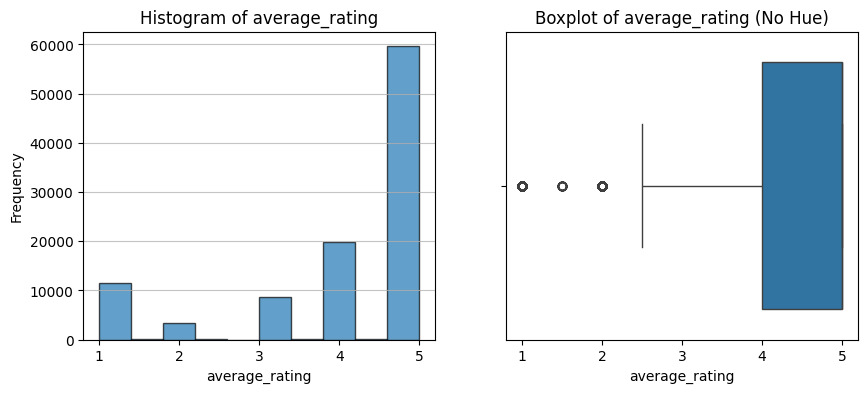

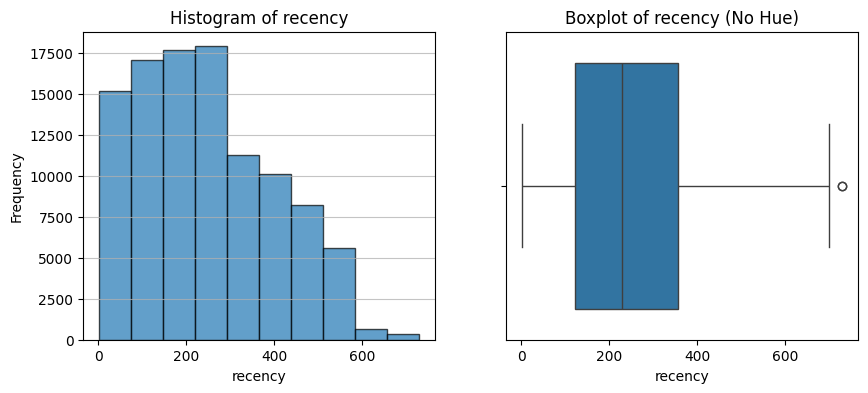

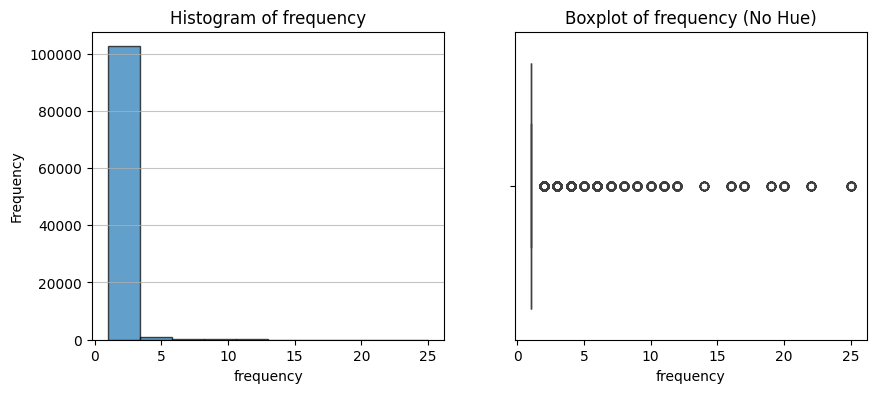

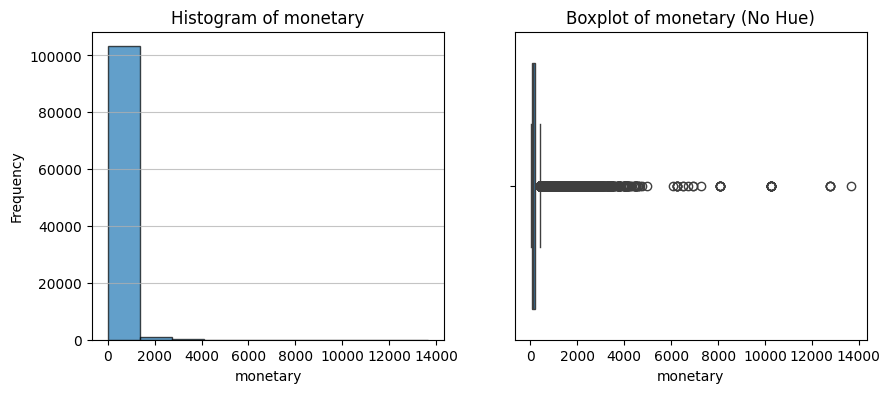

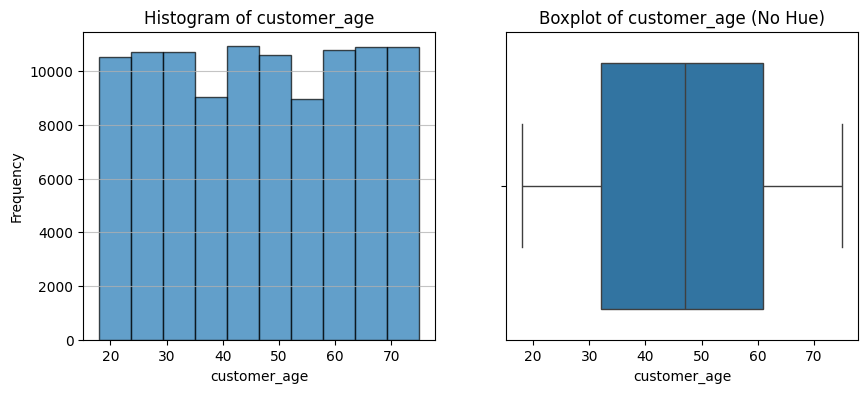

In [18]:
# EDA Continuous variables

for col in con_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

    ax1.hist(segment_df[col], bins = 10, edgecolor = 'black', alpha = 0.7)
    ax1.set_title(f'Histogram of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.75)

    if isinstance(segment_df[col].dtype, pd.CategoricalDtype):
        sns.boxplot(x = segment_df[col], ax=ax2)
    else:
        sns.boxplot(x = segment_df[col], ax=ax2)
    ax2.set_title(f'Boxplot of {col} (No Hue)')
    ax2.set_xlabel(col)

    plt.show()

### 4.2) Standardize Data



In [19]:
scaler = StandardScaler()
scaler.fit(segment_df)
df_scaled = pd.DataFrame(scaler.transform(segment_df), columns = cat_cols + con_cols)

df_scaled.describe()

,category_agriculture,category_arts_crafts,category_auto,category_baby,category_books_media,category_electronics,category_fashion,category_festive,category_food_drinks,category_health_beauty,...,customer_region_southeast,payment_type_cash,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,average_rating,recency,frequency,monetary,customer_age
count,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,...,9.681000e+04,9.681000e+04,9.681000e+04,9.681000e+04,9.681000e+04,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05,1.041580e+05
mean,-3.987329e-17,4.038492e-17,-6.303323e-17,1.964672e-17,-4.993541e-17,6.821778e-19,1.009623e-17,-3.521743e-17,5.580214e-17,3.922522e-18,...,-4.543187e-17,2.686279e-17,-2.730316e-17,-1.379837e-17,6.664320e-17,5.327808e-17,1.139237e-16,-1.814593e-17,-1.046461e-16,-3.274453e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.598533e+00,-2.114315e-01,-5.721590e-01,-4.483973e-02,-2.009825e-01,-2.022716e-01,-1.736243e-01,-1.257336e-01,-4.593766e-01,-1.608222e-01,...,-2.500302e-01,-1.372130e-01,-3.245401e-01,-4.074214e-01,-1.474765e+00,-4.863149e-01,-1.783029e+00,-1.225439e-01,-1.853650e-01,-1.711277e+00
25%,-8.107966e-01,-2.114315e-01,-3.900391e-01,-4.483973e-02,-2.009825e-01,-2.022716e-01,-1.736243e-01,-1.257336e-01,-4.593766e-01,-1.608222e-01,...,-2.500302e-01,-1.372130e-01,-3.245401e-01,-4.074214e-01,-1.474765e+00,-4.863149e-01,5.608434e-01,-1.225439e-01,-1.853650e-01,-8.743345e-01
50%,-1.207134e-01,-2.114315e-01,-2.423104e-01,-4.483973e-02,-2.009825e-01,-2.022716e-01,-1.736243e-01,-1.257336e-01,-4.593766e-01,-1.608222e-01,...,-2.500302e-01,-1.372130e-01,-3.245401e-01,-4.074214e-01,6.780742e-01,-4.863149e-01,5.608434e-01,-1.225439e-01,-1.853650e-01,2.238984e-02
75%,7.191049e-01,-2.114315e-01,2.413340e-02,-4.483973e-02,-2.009825e-01,-2.022716e-01,-1.736243e-01,-1.257336e-01,-4.593766e-01,-1.608222e-01,...,-2.500302e-01,-1.372130e-01,-3.245401e-01,-4.074214e-01,6.780742e-01,-4.863149e-01,5.608434e-01,-1.225439e-01,-1.853650e-01,8.593325e-01
max,3.140907e+00,2.238518e+01,4.308141e+01,2.230165e+01,4.975558e+00,4.943847e+00,5.759564e+00,7.953326e+00,2.176863e+00,6.218049e+00,...,3.999517e+00,7.287937e+00,3.081284e+00,2.454461e+00,6.780742e-01,2.056281e+00,5.608434e-01,8.160342e+00,5.394763e+00,1.696275e+00


In [20]:
df_scaled.dropna(inplace = True)
segment_df.dropna(inplace = True)

### 4.3) PCA

In [21]:
pca = PCA(n_components = 2)

df_pca = pd.DataFrame(data = pca.fit_transform(df_scaled), columns = ['Principal Component 1', 'Principal Component 2'])

df_pca.head()

,Principal Component 1,Principal Component 2
0,-1.187667,-0.833090
1,-1.180484,-0.928387
2,-1.176418,-0.808861
3,0.062814,-1.063904
4,-1.205389,-0.857884


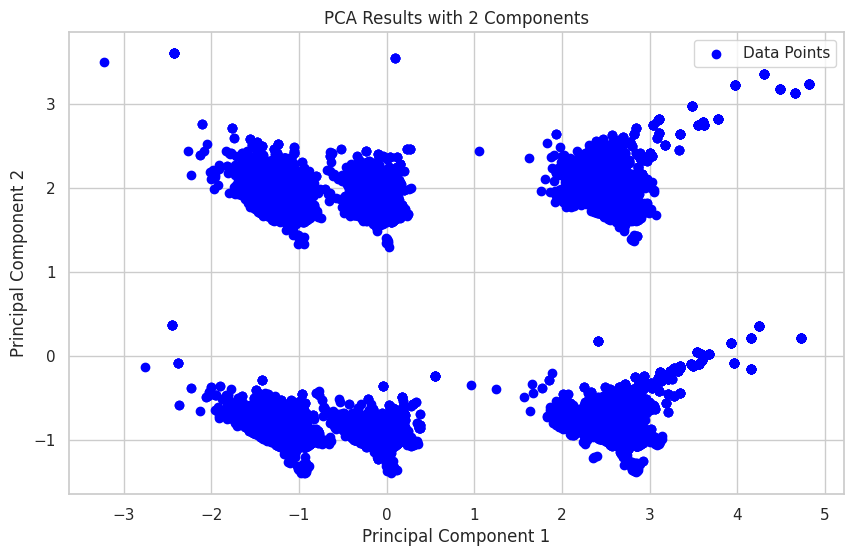

In [22]:
# Visualize

sns.set(style = "whitegrid")

plt.figure(figsize = (10, 6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c = 'blue', label = 'Data Points')

plt.title('PCA Results with 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.show()

## Step5: Evaluation Scores

### 5.1) Elbow Method

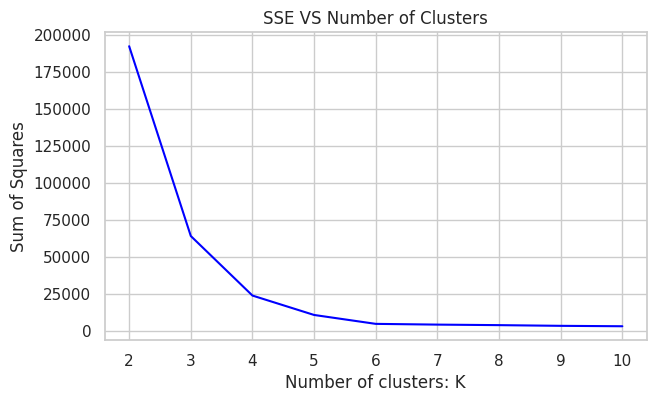

In [23]:
# Elbow

n_clusters = range(2, 11)

inertia_scores = []
for n in n_clusters:
    inertia = KMeans(n_clusters = n, random_state = 42).fit(df_pca).inertia_
    inertia_scores.append(inertia)

# Plot Elbow
plt.figure(figsize=[7, 4])
plt.plot(range(2, 11), inertia_scores, color='blue')
plt.title("SSE VS Number of Clusters")
plt.xlabel('Number of clusters: K')
plt.ylabel('Sum of Squares')
plt.show()

### 5.2) Silhouette Score

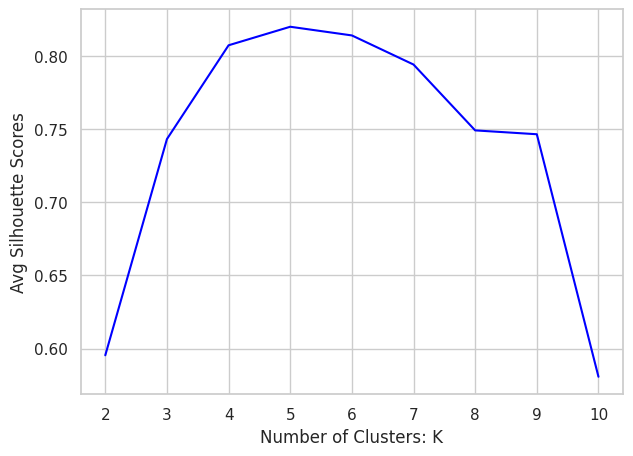

In [24]:
# Calculate silhouette score for different K clusters

silhouette_scores_normal = []

for k in range(2,11):
    model = KMeans(n_clusters = k, random_state = 42)
    clusters = model.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, clusters)
    silhouette_scores_normal.append(silhouette_avg)

# Plot
plt.figure(figsize = [7,5])
plt.plot(range(2,11), silhouette_scores_normal, color = 'blue')
plt.xlabel('Number of Clusters: K')
plt.ylabel('Avg Silhouette Scores')
plt.show()

In [25]:
silhouette_scores_normal

[0.595423930841633,
 0.7431428239895945,
 0.8072230234547303,
 0.8198873570589305,
 0.8139574550193203,
 0.7940648417821703,
 0.749077835808723,
 0.7464444122326717,
 0.580756331980825]

### 5.3) Davies Bouldin Scores

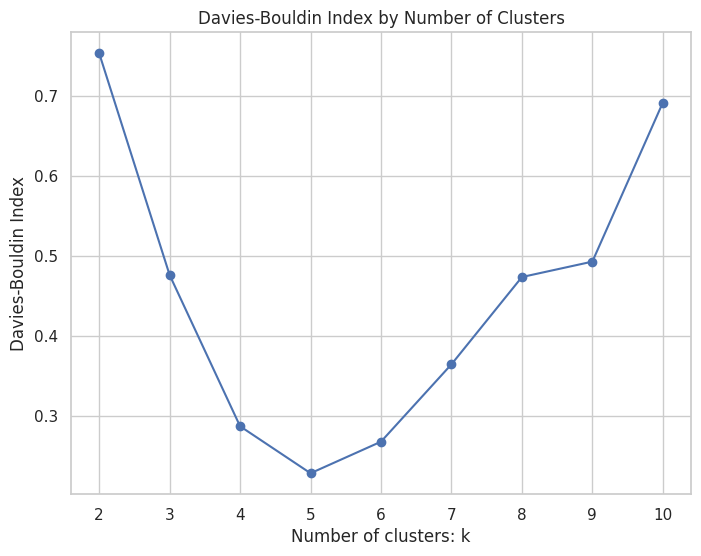

In [26]:
davies_bouldin_scores = []

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = 42)
    clusters = model.fit_predict(df_pca)
    db_score = davies_bouldin_score(df_pca, clusters)
    davies_bouldin_scores.append(db_score)


plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index by Number of Clusters')
plt.xlabel('Number of clusters: k')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [27]:
for k, score in enumerate(davies_bouldin_scores, start=2):
    print(f"clusters (k): {k}, Davies-Bouldin Score: {score}")

clusters (k): 2, Davies-Bouldin Score: 0.7535320696949231
clusters (k): 3, Davies-Bouldin Score: 0.476392399900522
clusters (k): 4, Davies-Bouldin Score: 0.287404243835586
clusters (k): 5, Davies-Bouldin Score: 0.22869219521158118
clusters (k): 6, Davies-Bouldin Score: 0.2681427727624825
clusters (k): 7, Davies-Bouldin Score: 0.36482259863049354
clusters (k): 8, Davies-Bouldin Score: 0.4738885196215299
clusters (k): 9, Davies-Bouldin Score: 0.4931510005231381
clusters (k): 10, Davies-Bouldin Score: 0.6918029889047904


## Step6: K-Means

### 6.1) K = 4

In [28]:
# Cluster(K-Means): K = 4

# Model Fit
model_k4 = KMeans(n_clusters = 4, random_state = 42)
model_k4.fit(df_pca)

# Predict
clusters_k4 = model_k4.predict(df_pca)
df_pca['Cluster_K4'] = clusters_k4
segment_df['Cluster_K4'] = clusters_k4

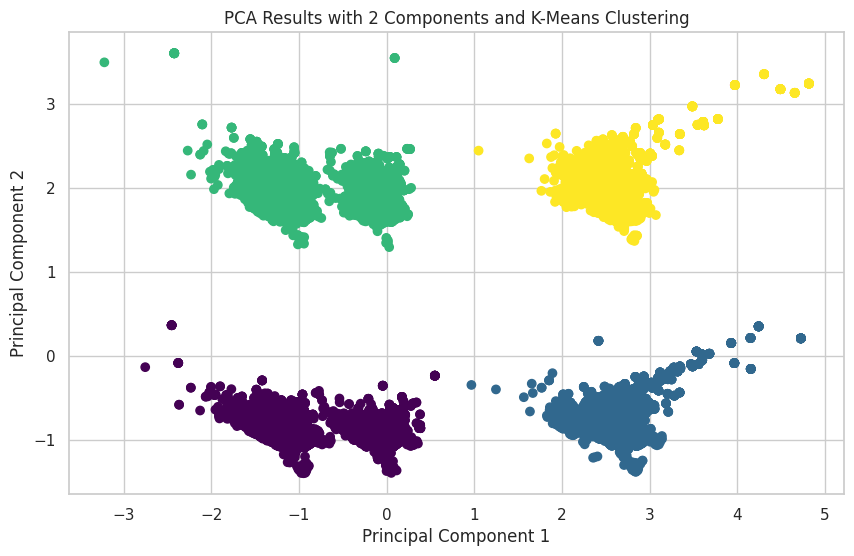

In [29]:
# Visualize Clusters (K = 4)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'],
                      c = df_pca['Cluster_K4'], cmap = 'viridis', label = 'Cluster Label')

plt.title('PCA Results with 2 Components and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### 6.2) K = 6

In [30]:
# Cluster(K-Means): K = 6

# Model Fit
model_k6 = KMeans(n_clusters = 6, random_state = 42)
model_k6.fit(df_pca)

# Predict
clusters_k6 = model_k6.predict(df_pca)
df_pca['Cluster_K6'] = clusters_k6
segment_df['Cluster_K6'] = clusters_k6

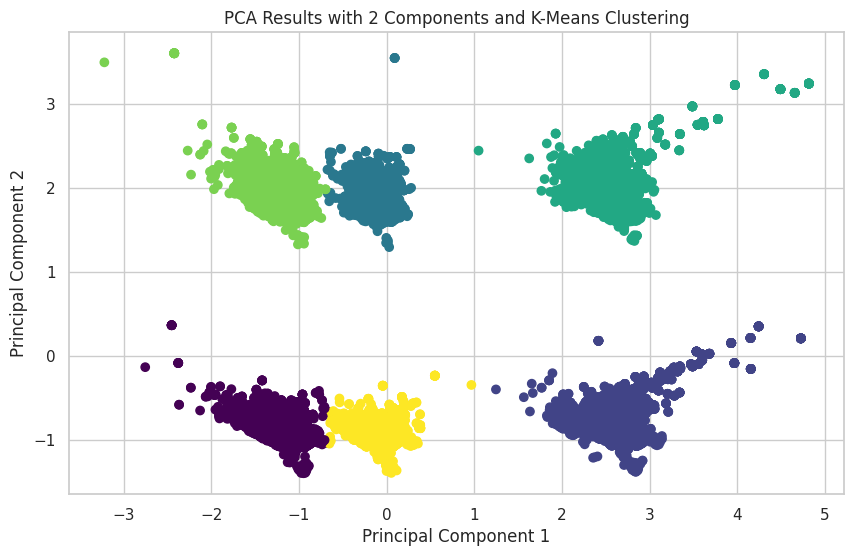

In [31]:
# Visualize Clusters (K = 6)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'],
                      c = df_pca['Cluster_K6'], cmap = 'viridis', label = 'Cluster Label')

plt.title('PCA Results with 2 Components and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Step7: Conclusions

## K = 4
- Cluster 0: "High Spenders with Low Frequency"
- Cluster 1: "Moderate Spenders with Mixed Payment Methods"
- Cluster 2: "High Spenders from Northeast and South"
- Cluster3: "Frequent Shoppers with Low Spending"

In [32]:
# K = 4

segment_df['Cluster_K4'].value_counts()
segment_df.groupby('Cluster_K4').mean().T

Cluster_K4,0,1,2,3
recency,244.551168,253.440731,246.209980,256.397484
frequency,1.139207,1.415006,1.153247,1.560168
monetary,190.865325,160.604008,197.961560,159.098193
category_agriculture,0.001600,0.003846,0.001384,0.002236
category_arts_crafts,0.039551,0.036822,0.038182,0.040811
category_auto,0.039251,0.037011,0.040993,0.041090
category_baby,0.030273,0.027427,0.030053,0.025856
category_books_media,0.015196,0.017591,0.014745,0.016212
category_electronics,0.168380,0.200126,0.164187,0.192593
category_fashion,0.025054,0.026419,0.024994,0.025297


In [33]:
# K = 6

segment_df.groupby('Cluster_K6').mean().T

Cluster_K6,0,1,2,3,4,5
recency,249.854851,253.450659,236.502796,256.397484,251.390278,234.720176
frequency,1.100009,1.415032,1.218218,1.560168,1.118576,1.211793
monetary,231.503009,160.333821,125.722856,159.098193,236.512184,115.846195
category_agriculture,0.001478,0.003846,0.001367,0.002236,0.001393,0.001825
category_arts_crafts,0.044185,0.036825,0.028209,0.040811,0.043504,0.030965
category_auto,0.037380,0.037014,0.047720,0.041090,0.037403,0.042712
category_baby,0.030360,0.027429,0.031689,0.025856,0.029180,0.030109
category_books_media,0.013918,0.017593,0.018516,0.016212,0.012733,0.017564
category_electronics,0.128522,0.200139,0.235243,0.192593,0.126268,0.242188
category_fashion,0.023340,0.026420,0.026469,0.025297,0.024206,0.028228
